In [68]:
import warnings

warnings.filterwarnings("ignore")

In [90]:
import os
import tqdm
import yaml
import pandas as pd
import numpy as np

from evml.keras.models import CategoricalDNN, locate_best_model
from bridgescaler import load_scaler

from evml.classifier_uq import brier_multi
import tensorflow as tf
from collections import defaultdict

import matplotlib.pyplot as plt
from evml.pit import pit_deviation_skill_score

In [2]:
fn_config = "/glade/p/cisl/aiml/ai2es/winter_ptypes/models/classifier_weighted/model.yml"

#"/glade/scratch/schreck/repos/evidential/results/ptype/weighted/classifier/best.yml"

In [3]:
with open(fn_config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [4]:
input_features = (
    conf["TEMP_C"] + conf["T_DEWPOINT_C"] + conf["UGRD_m/s"] + conf["VGRD_m/s"]
)
output_features = conf["ptypes"]

In [5]:
model = CategoricalDNN.load_model(conf)

2023-06-23 14:14:47.152181: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/dav/opt/cuda/11.4.0/extras/CUPTI/lib64:/glade/u/apps/dav/opt/cuda/11.4.0/lib64:/glade/u/apps/dav/opt/openmpi/4.1.1/intel/19.1.1/lib:/glade/u/apps/dav/opt/ucx/1.11.0/lib:/glade/u/apps/opt/intel/2020u1/compilers_and_libraries/linux/lib/intel64:/glade/work/schreck/miniconda3/envs/evidential/lib/:/glade/work/schreck/miniconda3/envs/evidential/lib/python3.10/site-packages/nvidia/cudnn/lib
2023-06-23 14:14:47.152222: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for you

In [6]:
input_scaler_loc = os.path.join(conf["save_loc"], "scalers", "input.json")

input_scaler = load_scaler(input_scaler_loc)

In [7]:
best_split = locate_best_model(conf["save_loc"], conf["metric"], conf["direction"])

In [8]:
test_data_loc = os.path.join(conf["save_loc"], "evaluate", f"test_{best_split}.parquet")

test_data = pd.read_parquet(test_data_loc)

In [9]:
scaled_input_x = input_scaler.transform(test_data[input_features])

In [21]:
y_true = test_data[output_features].values

In [10]:
y_pred_test = model.predict(scaled_input_x)

In [12]:
brier_score = brier_multi(np.argmax(y_true, 1), y_pred_test)

In [13]:
brier_score

0.6016400985561967

In [38]:
def update_dropout(model, dropout = 0.1, input_shape = 84):
    new_model = tf.keras.Sequential()
    
    for layer in model.model.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            new_model.add(tf.keras.layers.Dropout(rate=dropout))
        else:
            new_model.add(layer)
    for i in range(len(new_model.layers)):
        new_model.layers[i].set_weights(model.model.layers[i].get_weights())
        
    new_model.build((model.batch_size, input_shape))
    new_model.compile(optimizer=model.optimizer_obj, loss=model.loss)
    model.model = new_model
    return model

In [39]:
model = update_dropout(model, 0.5)

In [41]:
pred_probs, aleatoric, epistemic, entropy, mutual_info = model.predict_monte_carlo(scaled_input_x)

/glade/work/schreck/miniconda3/envs/evidential/lib/python3.8/site-packages/evml/keras/models.py:908: RuntimeWarning: divide by zero encountered in log
  pred_probs * np.log(pred_probs + epsilon), axis=-1
/glade/work/schreck/miniconda3/envs/evidential/lib/python3.8/site-packages/evml/keras/models.py:908: RuntimeWarning: invalid value encountered in multiply
  pred_probs * np.log(pred_probs + epsilon), axis=-1
/glade/work/schreck/miniconda3/envs/evidential/lib/python3.8/site-packages/evml/keras/models.py:912: RuntimeWarning: divide by zero encountered in log
  np.sum(-y_prob * np.log(y_prob + epsilon), axis=-1), axis=0
/glade/work/schreck/miniconda3/envs/evidential/lib/python3.8/site-packages/evml/keras/models.py:912: RuntimeWarning: invalid value encountered in multiply
  np.sum(-y_prob * np.log(y_prob + epsilon), axis=-1), axis=0


In [42]:
brier_multi(np.argmax(y_true, 1), pred_probs)

0.5950503858633889

In [85]:
def drop_fraction_offset(test_data, uq_column, plot = False, num_classes = 4, num_bins = 10):
    df = test_data.copy()
    total = []
    for class_label in range(num_classes):
        df = df.sort_values(uq_column)
        dr = df[df["pred_label"] == class_label].copy()
        results = defaultdict(list)
        percentage = np.linspace(0, 1, dr.shape[0])
        for percent in np.linspace(5, 100, num_bins):
            c = percentage < percent / 100.0
            if c.sum() == 0:
                continue
            acc = (dr[c]["true_label"] == dr[c]["pred_label"]).mean()
            bss = brier_multi(
                dr[c]["true_label"].values,
                dr[c][[f"pred_conf{k+1}" for k in range(num_classes)]].values,
            )
            results["acc"].append(acc)
            results["bss"].append(bss)
            results["frac"].append(100-percent)
            # The best we can do is 1.0, add up the differences across the bins
            total.append(np.mean([1 - x for x in results["bss"]]))
            
        if plot:
            plt.plot(results["frac"], results["bss"])
    
    if plot:
        plt.tight_layout()
        plt.show()
    else:
        return np.mean(total)

In [ ]:
dropouts = np.arange(0, 1, 0.01) #[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]

scores = []
for dr in tqdm.tqdm(dropouts, total = len(dropouts)):
    model = update_dropout(model, dropout = dr)
    pred_probs, aleatoric, epistemic, entropy, mutual_info = model.predict_monte_carlo(scaled_input_x)
    test_data[[f"pred_conf{k+1}" for k in range(4)]] = pred_probs
    test_data[[f"ale{k+1}" for k in range(4)]] = aleatoric
    test_data[[f"epi{k+1}" for k in range(4)]] = epistemic
    test_data["entropy"] = entropy
    skill = drop_fraction_offset(test_data, "entropy")
    #print(dr, skill)
    scores.append(skill)

 10%|█         | 10/100 [04:27<40:49, 27.22s/it]

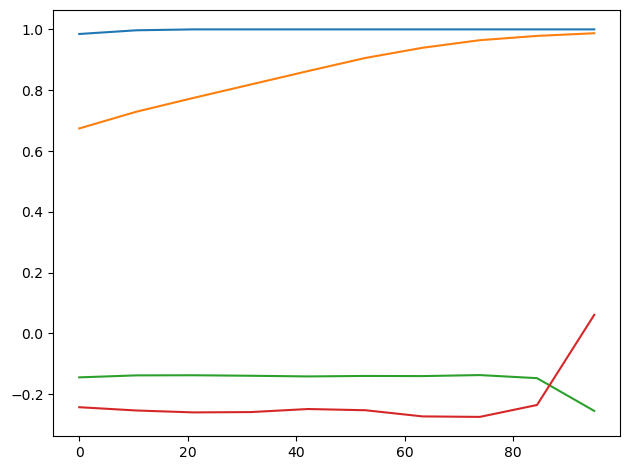

In [87]:
model = update_dropout(model, dropout = 0.2)
pred_probs, aleatoric, epistemic, entropy, mutual_info = model.predict_monte_carlo(scaled_input_x)
skill = drop_fraction_offset(test_data, "entropy", plot = True)

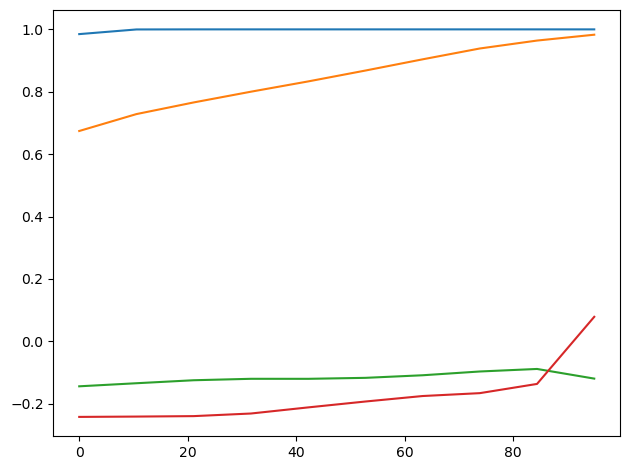

In [82]:
model = update_dropout(model, dropout = 0.7)
pred_probs, aleatoric, epistemic, entropy, mutual_info = model.predict_monte_carlo(scaled_input_x)
skill = drop_fraction_offset(test_data, "entropy", plot = True)